In [1]:
import numpy as np
import scipy.signal as ssgn
from matplotlib import pyplot as plt
%matplotlib inline

# работа со звуковыми файлами и данными
import aifc
import essentia.standard as es
import essentia

# вычисление вэйвлет преобразования
import pywt

import IPython

# собственные утилиты с функциями предобработки и визуализации 
import aif_preprocessor as aifp
from aif_preprocessor import aif_preprocessor
import graphics_utility as gru

In [2]:
import importlib
importlib.reload(aifp)
importlib.reload(gru)

<module 'graphics_utility' from '/media/user/DATA/Python_Projects/rb_tech/Python/graphics_utility.py'>

In [3]:
sample_path = '../data/commands/!select/bed/0a7c2a8d_nohash_0.aif'
#sample_path = '../data/commands/!select/bird/1b459024_nohash_0.aif'

In [4]:
FRAME_SIZE = 512
HOP_SIZE = 256

In [5]:
preprocessor = aif_preprocessor(sample_path, FRAME_SIZE, HOP_SIZE)

In [6]:
preprocessor.process()

#### Исходный файл.

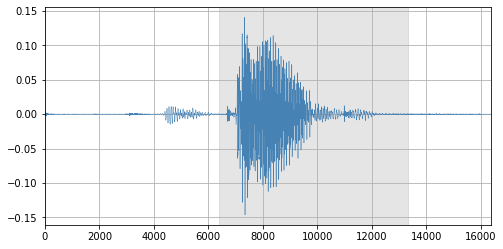

In [7]:
gru.plot_flagged_frames(
    preprocessor.float_data,
    aifp.markers_to_flags(
        preprocessor.audio_markers,
        preprocessor.audio_info.nframes,
        frame_size=FRAME_SIZE,
        hop_size=HOP_SIZE
    )[1]
)

#### Перекрывающиеся сегменты, содержащие полезный сигнал.

In [8]:
voice_frames = preprocessor.signal_frames

#### **Спектральные параметры:**
#### - амплитудный спектр с линейной шкалой частот,
#### - мел-спектр - спектр с нелинейной шкалой частот,
#### - мел-кепстр (спектр логарифма мел-спектра)

In [9]:
def get_mfcc(frames, sample_rate=16000, num_bands=64, num_coeffs=32, window_type='hann'):
    
    frame_size = len(frames[0])
    spectra = []
    melbands = []
    mfccs = []

    spectrum_estimator = es.Spectrum(size=frame_size)
    windowing = es.Windowing(type='hann', size=frame_size)
    mfcc_estimator = es.MFCC(
        numberBands=num_bands, numberCoefficients=num_coeffs+1,
        inputSize=frame_size,
        sampleRate=sample_rate, highFrequencyBound=8000
    )

    for frame in frames:    
        spectrum = spectrum_estimator(windowing(frame))
        mfcc_bands, mfcc_coeffs = mfcc_estimator(spectrum)        
        spectra.append(spectrum)
        mfccs.append(mfcc_coeffs[1:])
        melbands.append(mfcc_bands)
    
    return np.array(spectra).T, np.array(melbands).T, np.array(mfccs).T

In [10]:
spectra, melbands, mfccs = get_mfcc(voice_frames)

#### Визуализация матрицы MFCC:

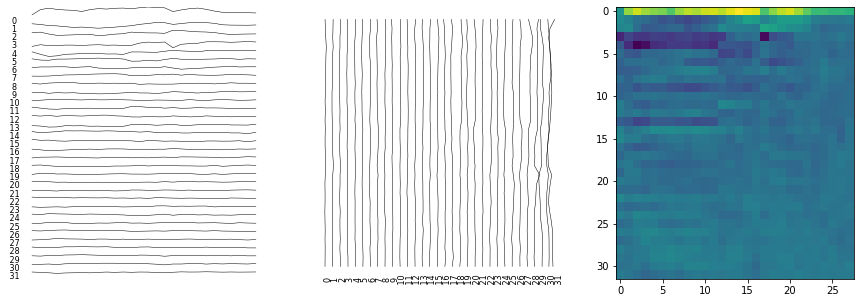

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))

gru.waterfall_plot(mfccs, left_right=False, add_indices=True, axes=ax[0], font_size=8)
gru.waterfall_plot(np.flipud(mfccs).T, left_right=True, add_indices=True, axes=ax[1], font_size=8)
ax[2].imshow(mfccs);

#### **Коэффициенты линейного предсказания**

In [12]:
def get_lpc(frames, sample_rate=16000, num_coeffs=32, window_type='hann'):
    frame_size = len(frames[0])
    lpc_coeffs = []
    reflection_coeffs = []
    
    lpc_estimator = es.LPC(sampleRate=sample_rate, order=num_coeffs-1)
    windowing = es.Windowing(type='hann', size=frame_size)
    
    for frame in frames:    
        lpc, reflection = lpc_estimator(windowing(frame) * 1000)
        lpc_coeffs.append(lpc)
        reflection_coeffs.append(reflection)
    
    return np.array(lpc_coeffs).T, np.array(reflection_coeffs).T

In [13]:
lpc, reflection = get_lpc(voice_frames)

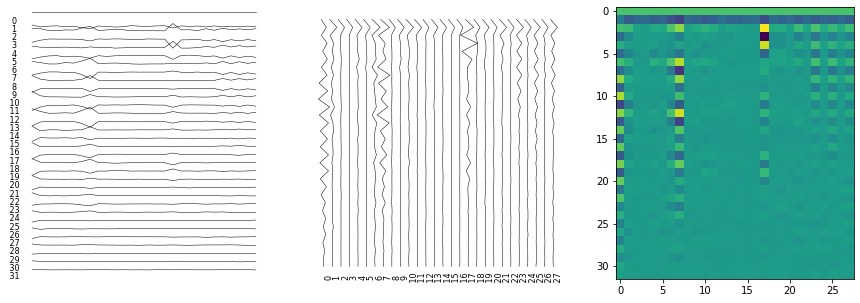

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))

gru.waterfall_plot(lpc, left_right=False, add_indices=True, axes=ax[0], font_size=8)
gru.waterfall_plot(lpc, left_right=True, add_indices=True, axes=ax[1], font_size=8)
ax[2].imshow(lpc);

#### **Constant-Q преобразование - отклики системы полосовых фильтров,**
#### **чьи центральные частоты распределены логарифмически по оси частот.**

In [15]:
def get_constantq(frames, sample_rate=16000, num_bands=64):
    max_freq = 8000
    min_freq = 125
    num_octaves = np.log2(max_freq / min_freq)
    bins_per_octave = int(np.ceil(num_bands / num_octaves))
    
    frame_size = len(frames[0])
    const_q_spectra = []

    spectrum_estimator = es.Spectrum(size=frame_size)
    if num_bands==16:
        padding_size = max([0, 512 - frame_size])
    elif num_bands==32:
        padding_size = max([0, 2048 - frame_size])
    else:
        padding_size = max([0, 1024 - frame_size])
        
    windowing = es.Windowing(type='hann', size=frame_size, zeroPadding=padding_size)
    
    constantq_estimator = es.ConstantQ(
        binsPerOctave=bins_per_octave,
        minFrequency=min_freq,
        numberBins=num_bands,
        sampleRate=sample_rate
    )
    for frame in frames:    
        const_q_spectrum = constantq_estimator(windowing(frame))  
        const_q_spectra.append(np.abs(const_q_spectrum))
    
    return np.array(const_q_spectra).T

In [16]:
constant_q = get_constantq(voice_frames, num_bands=32)

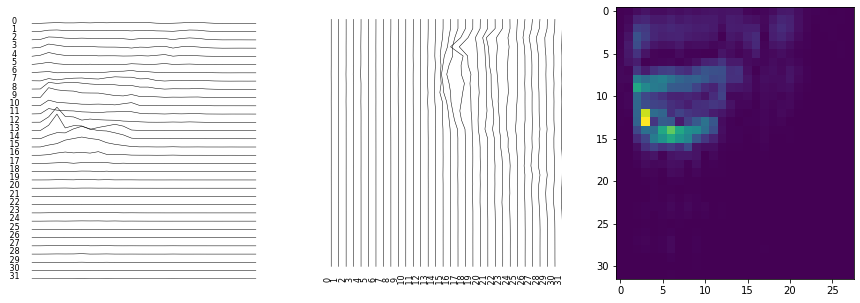

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))

gru.waterfall_plot(constant_q, left_right=False, add_indices=True, axes=ax[0], font_size=8)
gru.waterfall_plot(np.flipud(constant_q).T, left_right=True, add_indices=True, axes=ax[1], font_size=8)
ax[2].imshow(constant_q);

#### **Спектральные огибающие на основе коэффициентов линейного предсказания.**

In [18]:
def compress_range(x, factor=16):
    N = len(x)
    indices = []
    for i in range(int(np.log2(N)*factor)):
        indices.append(int(np.power(2, i/factor)))
    indices.append(N-1)
    output = []
    for i in range(1,len(indices)):
        output.append(np.max(x[indices[i] : indices[i] + 1]))
    return output

In [19]:
def get_spectrum_envelopes(lpc, sample_rate=16000, num_bands=64):
    spectrum_envelopes = []
    num_lin_freqs = int(np.ceil(np.power(2, num_bands/5)))    
    for lp_coeffs in lpc.T:
        freqs, complex_transfer = ssgn.freqz(1, lp_coeffs, worN=num_lin_freqs, fs=sample_rate)
        log_power_spectrum = np.log10(np.abs(complex_transfer)+1)**2                        
        log_freq = compress_range(log_power_spectrum, factor=5)        
        spectrum_envelopes.append(log_freq)
    return np.array(spectrum_envelopes).T

In [20]:
sp_envelopes = get_spectrum_envelopes(lpc, num_bands=32)

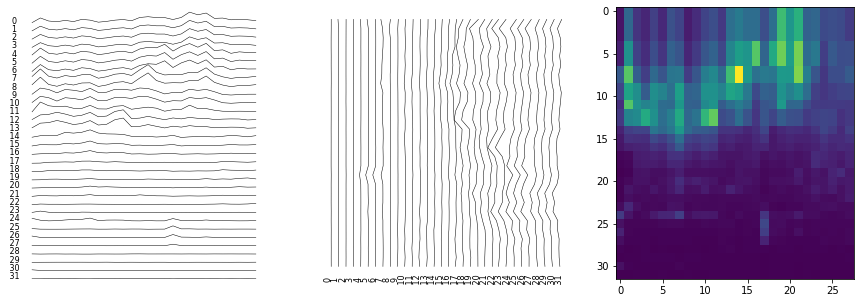

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))

gru.waterfall_plot(sp_envelopes, left_right=False, add_indices=True, axes=ax[0], font_size=8)
gru.waterfall_plot(np.flipud(sp_envelopes).T, left_right=True, add_indices=True, axes=ax[1], font_size=8)
ax[2].imshow(sp_envelopes);

#### **Огибающие компонент пакетного вэйвлет-преобразования.**

In [22]:
def get_wavelet_envelopes(frames, level=5, window_type='hann'):
    frame_size = len(frames[0])
    num_bands = 2**level
    output_envelopes = {i: [] for i in range(num_bands)}
    windowing = es.Windowing(type='hann', size=frame_size)
    
    for frame in frames:
        wp = pywt.WaveletPacket(data=windowing(frame), wavelet='db1', mode='zero', maxlevel=level)
        for i in range(num_bands):            
            band_key = bin(i).replace('0b','').zfill(level).replace('0', 'a').replace('1','d')            
            output_envelopes[i].append(np.std(wp[band_key].data))
    
    output_array = []
    for item in output_envelopes.values():
        output_array.append(list(item))
    
    return np.array(output_array)

In [23]:
wp_envelopes = get_wavelet_envelopes(voice_frames, level=5)

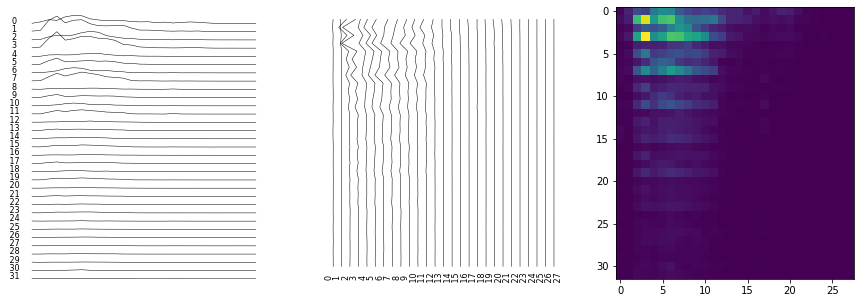

In [24]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))

gru.waterfall_plot(wp_envelopes, left_right=False, add_indices=True, axes=ax[0], font_size=8)
gru.waterfall_plot(wp_envelopes, left_right=True, add_indices=True, axes=ax[1], font_size=8)
ax[2].imshow(wp_envelopes);